In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import lmdb
import pickle
from os.path import join
from PIL import Image

In /opt/conda/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/conda/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.

In [4]:
dataset_name = 'gopro' # replace with the directory name of your dataset
data_root = '../' # replace with your own path
data_path = join(data_root, dataset_name)
lmdb_path = join(data_root, dataset_name+'_lmdb')

os.makedirs(lmdb_path, exist_ok=True)

In [5]:
for dataset_type in ['train', 'test']:

    # create meta-info pkl files for the dataset
    path = join(data_path, dataset_type)
    seqs = os.listdir(path)
    seqs_info = {}
    length = 0
    for i in range(len(seqs)):
        seq_info = {}
        seq_info['seq'] = seqs[i]
        length_temp = len(os.listdir(join(path,seqs[i],'blur_gamma')))
        seq_info['length'] = length_temp
        length += length_temp
        seqs_info[i] = seq_info
    seqs_info['length'] = length
    seqs_info['num'] = len(seqs)
    f = open(join(lmdb_path,'{}_info_{}.pkl'.format(dataset_name, dataset_type)), 'wb')
    pickle.dump(seqs_info, f)
    f.close()
    
    for dataset_label in [dataset_type, '{}_gt'.format(dataset_type)]:
        for i in range(seqs_info['num']):
            env = lmdb.open(join(lmdb_path, '{}_{}'.format(dataset_name, dataset_label)), map_size=10737418240)
            txn = env.begin(write=True)
            if dataset_label.endswith('gt'):
                subpath = join(path, seqs_info[i]['seq'], 'sharp')
            else:
                subpath = join(path, seqs_info[i]['seq'], 'blur_gamma')
            imgs = os.listdir(subpath)
            nums = [int(img.split('.')[0]) for img in imgs] # make sure your images are named by numbers, e.g., 0001.png.
            nums.sort()
            gap = nums[0]-0
            for img in imgs:
                img_path = join(subpath, img)
                seq_idx = i
                frame_idx = int(img.split('.')[0])-gap
                key = '%03d_%08d' % (seq_idx, frame_idx)
                data = Image.open(img_path)
                data = np.asarray(data)
                txn.put(key=key.encode(), value=data)
            txn.commit()
            env.close()

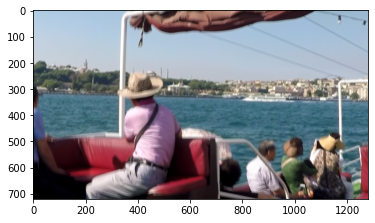

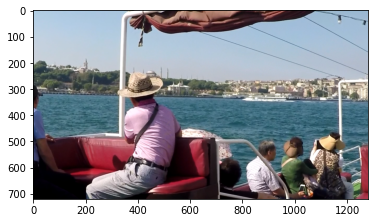

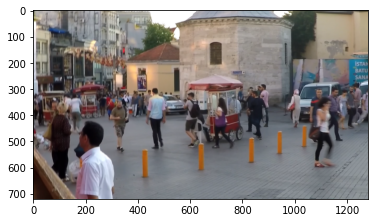

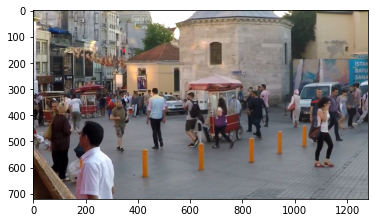

In [6]:
H,W,C = 720,1280,3
# tarin set
env = lmdb.open(join(lmdb_path, '{}_train'.format(dataset_name)), map_size=10737418240)
env_gt = lmdb.open(join(lmdb_path, '{}_train_gt'.format(dataset_name)), map_size=10737418240)
txn = env.begin()
txn_gt = env_gt.begin()
seq = 21
frame = 39
key = '{:03d}_{:08d}'.format(seq, frame)
test = txn.get(key.encode())
test = np.frombuffer(test, dtype='uint8')
test = test.reshape(H,W,C)
test_gt = txn_gt.get(key.encode())
test_gt = np.frombuffer(test_gt, dtype='uint8')
test_gt = test_gt.reshape(H,W,C)
plt.imshow(test)
plt.figure()
plt.imshow(test_gt)
plt.show()
env.close()
env_gt.close()
# valid set
env = lmdb.open(join(lmdb_path, '{}_test'.format(dataset_name)), map_size=10737418240)
env_gt = lmdb.open(join(lmdb_path, '{}_test_gt'.format(dataset_name)), map_size=10737418240)
txn = env.begin()
txn_gt = env_gt.begin()
seq = 8
frame = 39
key = '{:03d}_{:08d}'.format(seq, frame)
test = txn.get(key.encode())
test = np.frombuffer(test, dtype='uint8')
test = test.reshape(H,W,C)
test_gt = txn_gt.get(key.encode())
test_gt = np.frombuffer(test_gt, dtype='uint8')
test_gt = test_gt.reshape(H,W,C)
plt.imshow(test)
plt.figure()
plt.imshow(test_gt)
plt.show()
env.close()
env_gt.close()